*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

In Module 1, we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google)

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [ ]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=404126f13742adf3bd4dd2374392df4e5db589ba7e79d708bab2c0596e87bf77
  Stored in directory: /tmp/pip-ephem-wheel-cache-k2wgpvd6/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [ ]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2022-05-30 16:30:30--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     149  --.-KB/s    in 0s      

2022-05-30 16:30:31 (11.4 MB/s) - ‘requirements.txt’ saved [149/149]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 61.6 MB/s 
     |████████████████████████████████| 10.4 MB 36.7 MB/s 
     |████████████████████████████████| 7.1 MB 79.8 MB/s 
     |████████████████████████████████| 208 kB 59.8 MB/s 
     |████████

##1.0.3 Imports and such

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

# Part 1: Building a Latent Dirichlet Allocation (LDA) Topic Model with Gensim

Our goal in this module is to get hands-on experience in how to build and train a Latent Dirichlet Allocation topic model using the **Gensim** library.

## 1.1 Latent Dirichlet Allocation (LDA)
is a more sophisticated method of topic modelling than Latent Semantic Indexing (LSI) which we used in Module 2. Because of its complexity, a full discussion of the machinery of LDA is beyond the scope of Unit 4. We'll focus on a high level of understanding of Latent Dirichlet Allocation, meaning we'll emphasize "what it does" rather than "how it does it".

LDA takes as input the corpora of documents and the number of topics that you want to identify. LDA models topics as probability distributions over words, and it models documents as probability distributions over topics.

LDA is a generative probabilistic model. That means it can generate documents from probability distributions. Given an article length (number of words), an assumed probability distribution of topics, and an assumed distribution of words for each topic, LDA can generate an article, in the form of a bag of words. LDA works by starting with random distributions of words over topics and  topics over documents, then iteratively adjust these probability distributions until the generated documents are similar in structure to the input documents.





### 1.1.1 Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended Medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/) is an interactive data visualization tool -- created by the author of the above article -- that allows us to explore a simple and visual example of LDA.

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) disccusses an example implementing LDA using the same dataset that we are using in this guided project.  

Luis Serrano's video [**Latent Dirichlet Allocation**](https://youtu.be/T05t-SqKArY) does a great job of breaking down and explaining LDA in an understandable way.



### 1.1.2 Further discussion of LDA (Optional)

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

A PGM can be represented by a graph that expresses the conditional dependence structure between random variables. Here's a graphical representation of the LDA model:

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

The image shows the hierarchical dependency between probability distributions and their parameters. This is an application of Hierarchical Bayesian Modeling.

In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources:

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using four popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

[**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning.

## 1.2 Preparing our text data set for LDA topic modeling with `gensim`
For this guided project we'll work with the `20newsgroups` data set that is  familiar from Module 3, but we'll extract articles from a different set of categories.<br><br>
`gensim` is a Natural Language Processing Library, specialized for Topic Modeling applications. The two main inputs required for a `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.<br><br>
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br><br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`.<br>

In this section, we will first download and clean the raw text documents, then use `spacy` to tokenize and lemmatize them. Then we'll use `gensim` to create the `id2word` and `corpus` objects that we need for topic modeling with `gensim`<br>

In Part 2, we'll build and train the LDA topic model in `gensim`.

References:
- [Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

# Problem Statement



We'll extract articles belonging to the following four topics (as assigned in the 20newsgroups database)

    sci
        \_ electronics, space


    talk
        \_politics
                  \_ guns, middle east
              
What's the best way to categorize these emails - is it between science and talk?

Or it between electronics, space, guns, and the Middle East?

The Middle East is a pretty broad topic in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer these questions!

### Load Email Corpus


In [ ]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics
categories = ['sci.electronics', 'sci.space',
              'rec.sport.baseball', 'rec.sport.hockey']
data = fetch_20newsgroups(subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

In [ ]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [ ]:
# create X and y from data, as we did in the Module 3 Lecture notebook
###BEGIN SOLUTION
X = data.data
y = data.target
target_names = data.target_names
###END SOLUTION

What are the possible targets (labels)

In [ ]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [ ]:
target_names

['rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics', 'sci.space']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [ ]:
data_dict = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data_dict)
print(df.shape)
df.head()

(3964, 3)


,content,target,target_names
0,\nWhat you have is one of the LD players from ...,2,sci.electronics
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space
2,Sounds like a job for a universal time recieve...,2,sci.electronics
3,"""Space Station Redesign Leader Says Cost Goal ...",3,sci.space
4,\nThey aren't going to leave a loophole as gla...,3,sci.space


Re-use our `clean_data()` helper function from Module 3.

In [ ]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document.

    Parameters
    ----------
    text: string or object

    Returns
    -------
    text: string or object
    """

    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"

    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)

    # apply case normalization
    return text.lower().lstrip().rstrip()

Clean the text string data and save it in a new column

In [ ]:
df["clean_data"] = df["content"].apply(clean_data)
df.head()

,content,target,target_names,clean_data
0,\nWhat you have is one of the LD players from ...,2,sci.electronics,what you have is one of the ld players from a ...
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space,well i thought it must have been a joke but i ...
2,Sounds like a job for a universal time recieve...,2,sci.electronics,sounds like a job for a universal time recieve...
3,"""Space Station Redesign Leader Says Cost Goal ...",3,sci.space,space station redesign leader says cost goal m...
4,\nThey aren't going to leave a loophole as gla...,3,sci.space,they aren t going to leave a loophole as glari...


### Create Tokens

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens.

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [ ]:
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_md", disable=['tagger', 'parser'])

In [ ]:
%%time
# create our tokens in the form of lemmas

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# Ref: https://github.com/nalepae/pandarallel
#
# from tqdm import tqdm
# tqdm.pandas()
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)

# Parallel_map takes about 20 sec
df['lemmas'] = df['clean_data'].parallel_map(lambda x: [token.lemma_.strip() for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 1.91 s, sys: 499 ms, total: 2.41 s
Wall time: 16.1 s


### Take a look at our lemmas

In [ ]:
df['clean_data'][12]

'i recently bought an apparantly complete expansion chassis by mountain computer inc it consists of a box with apple compatible slots powersupply brick interface card and ribbon cable to attach it to the computer to be expanded there was also included a small card with empty sockets on top and pins on the bottom that looks like it would plug into the motherboard somewhere after pulling a chip there s an empty socket also on the interface card and a short pin dip jumper like the ones used with language cards this technological marvel came with no docs and i haven t a clue as how to hook this thing up if anyone has docs and or users disk of any sort for this i could really use copies of them or at least some help i need to know o how to orient the ribbon cable between the card and the chassis o how to attach the short cable from the motherboard to the card and if the small card is used o the purposes of the various jumper pins on the card it has more of those than my cms scsi card'

In [ ]:
# print out the lemmas from the first article
# note that some lemmas are only 1 character: you could modify the code above to not include lemmas that are only 1 or 2 characters
df['lemmas'][12]

['recently',
 'buy',
 'apparantly',
 'complete',
 'expansion',
 'chassis',
 'mountain',
 'computer',
 'inc',
 'consist',
 'box',
 'apple',
 'compatible',
 'slot',
 'powersupply',
 'brick',
 'interface',
 'card',
 'ribbon',
 'cable',
 'attach',
 'computer',
 'expand',
 'include',
 'small',
 'card',
 'socket',
 'pin',
 'look',
 'like',
 'plug',
 'motherboard',
 'pull',
 'chip',
 's',
 'socket',
 'interface',
 'card',
 'short',
 'pin',
 'dip',
 'jumper',
 'like',
 'one',
 'language',
 'card',
 'technological',
 'marvel',
 'come',
 'doc',
 'haven',
 't',
 'clue',
 'hook',
 'thing',
 'doc',
 'user',
 'disk',
 'sort',
 'use',
 'copy',
 'help',
 'need',
 'know',
 'o',
 'orient',
 'ribbon',
 'cable',
 'card',
 'chassis',
 'o',
 'attach',
 'short',
 'cable',
 'motherboard',
 'card',
 'small',
 'card',
 'o',
 'purpose',
 'jumper',
 'pin',
 'card',
 'cm',
 'scsi',
 'card']

### Filter out low quality lemmas
1 or 2 characters

In [ ]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [ ]:
# apply filter_lemmas
# YOUR CODE HERE
df["filtered_lemmas"] = df["lemmas"].parallel_map(filter_lemmas)

In [ ]:
df["filtered_lemmas"][12]

['recently',
 'buy',
 'apparantly',
 'complete',
 'expansion',
 'chassis',
 'mountain',
 'computer',
 'inc',
 'consist',
 'box',
 'apple',
 'compatible',
 'slot',
 'powersupply',
 'brick',
 'interface',
 'card',
 'ribbon',
 'cable',
 'attach',
 'computer',
 'expand',
 'include',
 'small',
 'card',
 'socket',
 'pin',
 'look',
 'like',
 'plug',
 'motherboard',
 'pull',
 'chip',
 'socket',
 'interface',
 'card',
 'short',
 'pin',
 'dip',
 'jumper',
 'like',
 'one',
 'language',
 'card',
 'technological',
 'marvel',
 'come',
 'doc',
 'haven',
 'clue',
 'hook',
 'thing',
 'doc',
 'user',
 'disk',
 'sort',
 'use',
 'copy',
 'help',
 'need',
 'know',
 'orient',
 'ribbon',
 'cable',
 'card',
 'chassis',
 'attach',
 'short',
 'cable',
 'motherboard',
 'card',
 'small',
 'card',
 'purpose',
 'jumper',
 'pin',
 'card',
 'scsi',
 'card']

### The two main inputs to the `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

### Create the `id2word` dictionary

In [ ]:
# 1. Create Dictionary

# 2. Term Document Frequency is (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)

### BEGIN SOLUTION
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['filtered_lemmas'])

2022-05-30 17:38:39,912 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-05-30 17:38:40,276 : INFO : built Dictionary(21498 unique tokens: ['ace', 'ask', 'build', 'call', 'code']...) from 3964 documents (total 279355 corpus positions)


In [ ]:
# How many words do we have in our vocabulary?
len(id2word.keys())

21498

In [ ]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.5)

2022-05-30 17:38:54,486 : INFO : discarding 13166 tokens: [('lair', 1), ('technicial', 1), ('aloud', 2), ('geddit', 1), ('macalloon', 1), ('macaloon', 1), ('logisitics', 1), ('curtail', 1), ('furrow', 1), ('loophole', 1)]...
2022-05-30 17:38:54,487 : INFO : keeping 8332 tokens which were in no less than 3 and no more than 1982 (=50.0%) documents
2022-05-30 17:38:54,498 : INFO : resulting dictionary: Dictionary(8332 unique tokens: ['ace', 'ask', 'build', 'call', 'code']...)


In [ ]:
# Now how many words do we have in our vocabulary dictionary?
len(id2word.keys())

8332

Use the `id2word.doc2bow()` method to process a first document into a list of word counts

In [ ]:
df['clean_data'].iloc[5]

'boxscores beware the original poster looks to be from louisville and chances are louisville gets the edition of the nytimes that is printed in chicago for the midwest this edition has boxscores only on monday and sunday and an extremely skimpy sports section few game summaries mostly just color stories'

In [ ]:
id2word.doc2bow(df['filtered_lemmas'][5])

[(10, 1),
 (88, 1),
 (106, 1),
 (116, 1),
 (200, 1),
 (201, 2),
 (202, 1),
 (203, 1),
 (204, 1),
 (205, 2),
 (206, 1),
 (207, 2),
 (208, 1),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 1),
 (217, 1)]

### Create the `corpus`
by processing all the documents using a list comprehension

In [ ]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['filtered_lemmas']]

# Check the data type and length of corpus
print(type(corpus))
print(len(corpus))

<class 'list'>
3964


In [ ]:

### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

### END SOLUTION

[('game', 1),
 ('get', 1),
 ('look', 1),
 ('monday', 1),
 ('beware', 1),
 ('boxscores', 2),
 ('chance', 1),
 ('chicago', 1),
 ('color', 1),
 ('edition', 2),
 ('extremely', 1),
 ('louisville', 2),
 ('midwest', 1),
 ('original', 1),
 ('poster', 1),
 ('print', 1),
 ('section', 1),
 ('skimpy', 1),
 ('sport', 1),
 ('story', 1),
 ('summary', 1),
 ('sunday', 1)]

# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20,
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

#### The multi-processor version of gensim's LDA model is `gensim.models.ldamulticore.LdaMulticore()`, <br> which runs faster than the single-core version `gensim.models.ldamodel.LdaModel()`


In [ ]:
%%time
from gensim.models.ldamulticore import LdaMulticore


num_topics = 2
lda_multicore_2_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,              # Runtime related parameter
                                      per_word_topics=True,
                                      workers=10,             # Set based on your machine capability
                                      random_state=42)

2022-05-30 16:48:33,267 : INFO : using symmetric alpha at 0.5
2022-05-30 16:48:33,269 : INFO : using symmetric eta at 0.5
2022-05-30 16:48:33,274 : INFO : using serial LDA version on this node
2022-05-30 16:48:33,279 : INFO : running online LDA training, 2 topics, 20 passes over the supplied corpus of 3821 documents, updating every 2500 documents, evaluating every ~3821 documents, iterating 50x with a convergence threshold of 0.001000
2022-05-30 16:48:33,280 : INFO : training LDA model using 10 processes
2022-05-30 16:48:33,443 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #250/3821, outstanding queue size 1
2022-05-30 16:48:33,469 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #500/3821, outstanding queue size 2
2022-05-30 16:48:33,482 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #750/3821, outstanding queue size 3
2022-05-30 16:48:33,497 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #1000/3821, outstanding qu

CPU times: user 11.7 s, sys: 1.31 s, total: 13 s
Wall time: 20.6 s


In [ ]:
num_topics = 6
lda_multicore_6_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,
                                      per_word_topics=True,
                                      workers=10,
                                      random_state=42)

2022-05-30 17:41:01,124 : INFO : using symmetric alpha at 0.16666666666666666
2022-05-30 17:41:01,126 : INFO : using symmetric eta at 0.16666666666666666
2022-05-30 17:41:01,128 : INFO : using serial LDA version on this node
2022-05-30 17:41:01,137 : INFO : running online LDA training, 6 topics, 20 passes over the supplied corpus of 3964 documents, updating every 2500 documents, evaluating every ~3964 documents, iterating 50x with a convergence threshold of 0.001000
2022-05-30 17:41:01,139 : INFO : training LDA model using 10 processes
2022-05-30 17:41:01,394 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #250/3964, outstanding queue size 1
2022-05-30 17:41:01,416 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #500/3964, outstanding queue size 2
2022-05-30 17:41:01,418 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #750/3964, outstanding queue size 3
2022-05-30 17:41:01,431 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents 

# Part 3: Interpret LDA results & Select the appropriate number of topics
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>


### 3.1 Visualizing the topics in our models

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.10991  0.0       1        1  53.039466
0     -0.10991  0.0       2        1  46.960534, topic_info=          Term         Freq        Total Category  logprob  loglift
170      space  1292.000000  1292.000000  Default  30.0000  30.0000
538        gun  1212.000000  1212.000000  Default  29.0000  29.0000
527     israel   808.000000   808.000000  Default  28.0000  28.0000
711   armenian  1097.000000  1097.000000  Default  27.0000  27.0000
1609   turkish   647.000000   647.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
49      people   498.798631  2114.334261   Topic2  -5.8053  -0.6884
434        see   403.695860   676.907495   Topic2  -6.0169   0.2390
443       tell   401.024639   731.754207   Topic2  -6.0235   0.1544
279      start   396.520246   675.677186   Topic2  -6.0348   0.2229
1051       new   395.028680   741.846796   Topic2  -6.0386   0.1257

[190 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7249      1  0.994895      adl
7249      2  0.005922      adl
682       1  0.008601      amp
682       2  0.997722      amp
1759      1  0.010012  antenna
...     ...       ...      ...
1092      2  0.982061     wire
454       1  0.272735     work
454       2  0.727685     work
181       1  0.536266     year
181       2  0.464127     year

[295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.116078  0.163086       1        1  23.848622
0      0.084999 -0.125652       2        1  20.947054
3     -0.146117 -0.026305       3        1  19.664070
2     -0.009310 -0.173854       4        1  13.917686
1     -0.154050  0.063219       5        1  13.542565
4      0.340555  0.099507       6        1   8.080003, topic_info=        Term         Freq        Total Category  logprob  loglift
10      game  1883.000000  1883.000000  Default  30.0000  30.0000
24     space  1260.000000  1260.000000  Default  29.0000  29.0000
152     team  1284.000000  1284.000000  Default  28.0000  28.0000
1090     pit   346.000000   346.000000  Default  27.0000  27.0000
20      play  1078.000000  1078.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1178    lose   108.603125   366.253844   Topic6  -5.2639   1.3002
942    power   128.870830   651.201733   Topic6  -5.0928   0.8958
1702  boston    93.738846   225.477943   Topic6  -5.4111   1.6381
20      play   136.475766  1078.083291   Topic6  -5.0354   0.4490
536    score    84.842549   496.373776   Topic6  -5.5108   0.7492

[454 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4444      4  0.966605        aaa
2942      2  0.953774        abc
2942      3  0.027646        abc
2942      6  0.013823        abc
3012      1  0.017625        ahl
...     ...       ...        ...
1753      4  0.104764       york
1753      5  0.020953       york
1753      6  0.572710       york
4418      6  0.956617  zelepukin
6458      3  0.912368       zinc

[1049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 3, 2, 5])

###3.2 What is topic coherence?


_Topic Coherence measures score a single topic by
measuring the degree of semantic similarity between
high scoring words in the topic._ <br>
-- From "Exploring Topic Coherence over many models and many topics", by Keith Stevens, Philip Kegelmeyer, David Andrzejewski, and David Buttler, Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural
Language Learning, pages 952–961, Jeju Island, Korea, 12–14 July 2012.
c 2012 Association for Computational Linguistics

_A set of statements or facts is said to be coherent, if they
support each other. Thus, a coherent fact set can be interpreted
in a context that covers all or most of the facts. An
example of a coherent fact set is 'the game is a team sport',
'the game is played with a ball', and 'the game demands great
physical e
fforts'_ -- from "Exploring the Space of Topic Coherence Measures", by Michael Roder, Andreas Both and Alexander Hinneburg https://dl.acm.org/doi/10.1145/2684822.2685324

We expect that documents in a topic category should be coherent, i.e., they should relate to each other. The same is true for words within a topic.


### Let's tune the "number of topics" hyperparameter
and choose the model with the best Topic Coherence score.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['filtered_lemmas'], start=2, limit=10, step=1)

Streaming output truncated to the last 5000 lines.
2022-05-30 17:41:54,895 : INFO : 7 batches submitted to accumulate stats from 448 documents (-10517 virtual)
2022-05-30 17:41:54,907 : INFO : 9 batches submitted to accumulate stats from 576 documents (-11621 virtual)
2022-05-30 17:41:55,129 : INFO : 22 batches submitted to accumulate stats from 1408 documents (-35905 virtual)
2022-05-30 17:41:55,154 : INFO : 23 batches submitted to accumulate stats from 1472 documents (-34388 virtual)
2022-05-30 17:41:55,340 : INFO : 33 batches submitted to accumulate stats from 2112 documents (-51679 virtual)
2022-05-30 17:41:55,446 : INFO : 39 batches submitted to accumulate stats from 2496 documents (-63836 virtual)
2022-05-30 17:41:55,727 : INFO : serializing accumulator to return to master...
2022-05-30 17:41:55,732 : INFO : accumulator serialized
2022-05-30 17:41:55,736 : INFO : serializing accumulator to return to master...
2022-05-30 17:41:55,745 : INFO : accumulator serialized
2022-05-30 17:4

CPU times: user 1min 4s, sys: 9.18 s, total: 1min 13s
Wall time: 1min 56s


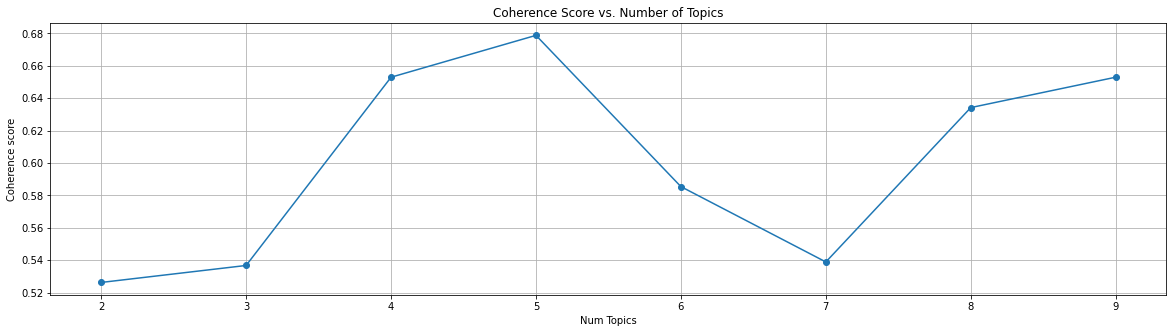

In [ ]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(x, coherence_values, "-o")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show();

### Select the "best" model as the one with the highest Topic Coherence Score

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus.

In [ ]:
lda_trained_model = model_list[3]

In [ ]:
lda_trained_model

### For each topic discovered by `gensim`, list the top ten words and their probabilities,

In [ ]:
pprint(lda_trained_model.print_topics())

2022-05-30 17:45:28,875 : INFO : topic #0 (0.200): 0.021*"game" + 0.014*"team" + 0.011*"play" + 0.010*"hockey" + 0.007*"season" + 0.007*"year" + 0.007*"player" + 0.006*"think" + 0.006*"goal" + 0.005*"win"
2022-05-30 17:45:28,878 : INFO : topic #1 (0.200): 0.008*"have" + 0.008*"use" + 0.008*"like" + 0.006*"know" + 0.006*"don" + 0.006*"work" + 0.005*"think" + 0.005*"wire" + 0.005*"time" + 0.005*"need"
2022-05-30 17:45:28,880 : INFO : topic #2 (0.200): 0.014*"year" + 0.014*"game" + 0.010*"win" + 0.009*"think" + 0.009*"team" + 0.008*"well" + 0.008*"hit" + 0.008*"player" + 0.007*"run" + 0.007*"don"
2022-05-30 17:45:28,881 : INFO : topic #3 (0.200): 0.016*"pit" + 0.015*"period" + 0.013*"det" + 0.012*"bos" + 0.011*"tor" + 0.010*"van" + 0.010*"chi" + 0.009*"nyi" + 0.008*"cal" + 0.008*"que"
2022-05-30 17:45:28,885 : INFO : topic #4 (0.200): 0.017*"space" + 0.007*"launch" + 0.006*"mission" + 0.006*"system" + 0.006*"orbit" + 0.006*"nasa" + 0.005*"earth" + 0.005*"satellite" + 0.005*"moon" + 0.005*

[(0,
  '0.021*"game" + 0.014*"team" + 0.011*"play" + 0.010*"hockey" + '
  '0.007*"season" + 0.007*"year" + 0.007*"player" + 0.006*"think" + '
  '0.006*"goal" + 0.005*"win"'),
 (1,
  '0.008*"have" + 0.008*"use" + 0.008*"like" + 0.006*"know" + 0.006*"don" + '
  '0.006*"work" + 0.005*"think" + 0.005*"wire" + 0.005*"time" + 0.005*"need"'),
 (2,
  '0.014*"year" + 0.014*"game" + 0.010*"win" + 0.009*"think" + 0.009*"team" + '
  '0.008*"well" + 0.008*"hit" + 0.008*"player" + 0.007*"run" + 0.007*"don"'),
 (3,
  '0.016*"pit" + 0.015*"period" + 0.013*"det" + 0.012*"bos" + 0.011*"tor" + '
  '0.010*"van" + 0.010*"chi" + 0.009*"nyi" + 0.008*"cal" + 0.008*"que"'),
 (4,
  '0.017*"space" + 0.007*"launch" + 0.006*"mission" + 0.006*"system" + '
  '0.006*"orbit" + 0.006*"nasa" + 0.005*"earth" + 0.005*"satellite" + '
  '0.005*"moon" + 0.005*"year"')]


###Visualize the topics in the best model

In [ ]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.139208 -0.149484       1        1  27.443393
1     -0.149896 -0.053588       2        1  24.923536
0      0.047615  0.116802       3        1  20.871560
2     -0.066312  0.162939       4        1  19.845796
3      0.307802 -0.076669       5        1   6.915714, topic_info=            Term         Freq        Total Category  logprob  loglift
10          game  1884.000000  1884.000000  Default  30.0000  30.0000
24         space  1241.000000  1241.000000  Default  29.0000  29.0000
1186      period   470.000000   470.000000  Default  28.0000  28.0000
152         team  1322.000000  1322.000000  Default  27.0000  27.0000
478       hockey   545.000000   545.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
942        power   104.506353   624.377840   Topic5  -5.1467   0.8839
20          play   111.911612  1036.240212   Topic5  -5.0783   0.4457
817   pittsburgh    72.136386   198.112367   Topic5  -5.5174   1.6611
198          win    98.347135   974.441974   Topic5  -5.2075   0.3780
89          goal    78.229779   455.116400   Topic5  -5.4363   0.9105

[370 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2942      1  0.028016         abc
2942      3  0.952528         abc
3238      3  0.981597  adirondack
3012      3  0.977566         ahl
1976      4  0.984497      alomar
...     ...       ...         ...
795       2  0.063150        year
795       3  0.247390        year
795       4  0.466135        year
795       5  0.003906        year
4418      5  0.973043   zelepukin

[825 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

## Create a Topic Id --> Topic Name dictionary


*****This is the "human intervention" step*****:<br>
Edit `vis_topic_name_dict` with YOUR OWN names that YOU assign to the topics that `gensim` discovered.

When populating your Topic Id --> Topic Name dictionary, use the index ordering as shown in the `pyLDAvis` tool.

In [ ]:
# keys - use topic ids from pyLDAvis visualization
# values - topic names that you create
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture
vis_topic_name_dict = {1:"space program",
                       2:"electronics / power",
                       3:"hockey",
                       4:"baseball",
                       5:"hockey teams / players"}
###END SOLUTION

## Create a Topic Id lookup dictionary
We'll use a function to map the `pyLDAvis` index ordering to the ordering used in gensim's trained LDA model.

In [ ]:
model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
model_vis_tool_topic_id_lookup

{0: 3, 1: 2, 2: 4, 3: 5, 4: 1}

In [ ]:
topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
topic_id_lookup

{1: 4, 2: 1, 3: 0, 4: 2, 5: 3}

In [ ]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model
    and the viz tool are different. So we need to create a look up dictionary that maps
    the correct association between topic ids from both sources.
    """
    # value is order of topic ids according to pyLDAvis tool
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that
    # key is order of topic ids accoridng to pyLDAvis tool
    # value is order of topic ids according to the trained lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}

    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [ ]:
###BEGIN SOLUTION
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has indexed the topics
# now we can use this dictionary with lda model to label our docs
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)
###END SOLTUION

In [ ]:
topic_name_dict

{0: 'hockey',
 1: 'electronics / power',
 2: 'baseball',
 3: 'hockey teams / players',
 4: 'space program'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name.

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output.

In [ ]:
def get_topic_ids_for_docs(lda_model, corpus):

    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document.

    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model

    corpus: nested lists of tuples,
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]

    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus
    """

    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:

        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)

        # iterate through the topic id/prob pairs
        for topic_id_prob in topic_id_prob_tuples:

            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)

    return doc_topic_ids

In [ ]:
# get the topic id for each doc in the corpus
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,\nWhat you have is one of the LD players from ...,2,sci.electronics,what you have is one of the ld players from a ...,"[ld, player, video, game, dragon, s, lair, spa...","[player, video, game, dragon, lair, space, ace...",1,electronics / power
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space,well i thought it must have been a joke but i ...,"[think, joke, don, t, joke, read, aloud, david...","[think, joke, don, joke, read, aloud, david, m...",2,baseball
2,Sounds like a job for a universal time recieve...,2,sci.electronics,sounds like a job for a universal time recieve...,"[sound, like, job, universal, time, reciever, ...","[sound, like, job, universal, time, reciever, ...",1,electronics / power
3,"""Space Station Redesign Leader Says Cost Goal ...",3,sci.space,space station redesign leader says cost goal m...,"[space, station, redesign, leader, say, cost, ...","[space, station, redesign, leader, say, cost, ...",4,space program
4,\nThey aren't going to leave a loophole as gla...,3,sci.space,they aren t going to leave a loophole as glari...,"[aren, t, go, leave, loophole, glare, space, m...","[aren, leave, loophole, glare, space, mine, pe...",4,space program


Using a boolean filter, or mask, you can slice out all articles of a certain topic, i.e. topic_id 3

In [ ]:
mask = df.topic_id == 2
df[mask]

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space,well i thought it must have been a joke but i ...,"[think, joke, don, t, joke, read, aloud, david...","[think, joke, don, joke, read, aloud, david, m...",2,baseball
18,Were they palying football or baseball in Detr...,0,rec.sport.baseball,were they palying football or baseball in detr...,"[palying, football, baseball, detroit, saturda...","[palying, football, baseball, detroit, saturda...",2,baseball
22,"\n\tSigh.\n\tI try to make a little joke, I tr...",3,sci.space,sigh i try to make a little joke i try to inje...,"[sigh, try, little, joke, try, inject, humour,...","[sigh, try, little, joke, try, inject, humour,...",2,baseball
23,"\n\nHmmmm, I'm not sure this is true. Accord...",1,rec.sport.hockey,hmmmm i m not sure this is true according to m...,"[hmmmm, be, sure, true, accord, mike, lang, go...","[hmmmm, sure, true, accord, mike, lang, good, ...",2,baseball
27,Al Weiss played second for the White Sox in th...,0,rec.sport.baseball,al weiss played second for the white sox in th...,"[al, weiss, play, 2, white, sox, early, sixty,...","[weiss, play, white, sox, early, sixty, chiefl...",2,baseball
...,...,...,...,...,...,...,...,...
3944,"\n\n\n\nGood comeback, Rog. Your quick wit an...",1,rec.sport.hockey,good comeback rog your quick wit and intellige...,"[good, comeback, rog, quick, wit, intelligence...","[good, comeback, rog, quick, wit, intelligence...",2,baseball
3945,discussing the fact that there were only 16 pl...,0,rec.sport.baseball,discussing the fact that there were only playe...,"[discuss, fact, player, hit, homeruns, steal, ...","[discuss, fact, player, hit, homeruns, steal, ...",2,baseball
3954,Since I was the one responsible for these dive...,0,rec.sport.baseball,since i was the one responsible for these dive...,"[responsible, divergent, thread, approx, post,...","[responsible, divergent, thread, approx, post,...",2,baseball
3959,Does anyone know if the Dick Estelle who does ...,0,rec.sport.baseball,does anyone know if the dick estelle who does ...,"[know, dick, estelle, radio, reader, npr, left...","[know, dick, estelle, radio, reader, npr, left...",2,baseball


In [ ]:
df[mask].target_names.value_counts(normalize=True)

rec.sport.baseball    0.850951
rec.sport.hockey      0.082452
sci.space             0.044397
sci.electronics       0.022199
Name: target_names, dtype: float64

In [ ]:
print(df.content.iloc[3])

"Space Station Redesign Leader Says Cost Goal May Be
Impossible"

Today (4/6) the Washington Post ran an article with the
headline shown above. The article starts with "A leader
of the NASA team in charge of redesigning the planned
space station said yesterday the job is tough and may
be impossible." O'Connor is quoted saying whether it is
possible to cut costs that much and still provide for
meaningful research "is a real question for me."
O'Connor said "everything is fair game," including
"dropping or curtailing existing contracts with the
aerospace industry, chopping management of the space
station program at some NASA facilities around the
country, working closely with the Russian space station
Mir, and using unmanned Titan rockets to supplement the
manned space shuttle fleet."

O'Connor says his team has reviewed 30 design options
so far, and they are sorting the serious candidates
into three categories based on cost.

The Post says O'Connor described the design derived
from the c

In [ ]:
# Extract Document-Topic distributions for each document in corpus
doc_lda = lda_trained_model[corpus]
doc_lda[3][0]

[(2, 0.024087185), (4, 0.9727234)]

In [ ]:
topic_name_dict

{0: 'hockey',
 1: 'electronics / power',
 2: 'baseball',
 3: 'hockey teams / players',
 4: 'space program'}

-----

## Knowledge is Power! What Can We Do with the Knowledge We Just Gained?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that you won't always have a point of reference to "check your answers". So let's explore two possible situations in which you might find yourself using Latent Dirichlet Allocation (LDA) Topic Modeling.

### 1. You have access to existing document topic labels

In this case, why would you bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, in this guided project, our email dataset has topic names; however those topic labels are hierarchical, which may not suit your needs. So one option is generate new labels that do suit your needs (as we did here).

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!

## Topic Modeling References


- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures